## limpieza

In [1]:
# Import the necessary libraries and functions
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
import time
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

In [2]:
# Leer el archivo Parquet
df = pd.read_parquet("DB_ML.parquet", engine="fastparquet")

In [3]:
print(df.shape)
df.head()

(571320, 42)


,Fecha,POTENCIA _ kW,PRESION ALIMENTADORES SAG_ KPa,PRESION DESCARGAS SAG_ Kpa,PESO TOTAL SAG_ ton,CORRIENTE ESTATOR SAG_ Amp,SOLIDOS SAG_ %,TORQUE SAG,TPH fresco SAG,RPM SAG,...,F80 FEEDER 4,F80 FEEDER 5,F80 FEEDER 6,F80 FEEDER 7,Ton SAG#1 a Pebble,Stockpile,% V Feeder 4,% V Feeder 5,% V Feeder 6,% V Feeder 7
0,2019-03-01 07:00:00,22851.059386,7442.802795,7326.981571,3123.465470,3745.792969,75.141449,23796.759043,3480.590445,9.169480,...,3.0,4.5,5.1,0.0,858.1,74.3,5.8,99.9,96.3,0.1
1,2019-03-01 07:01:00,22877.158502,7450.330352,7335.030702,3125.292839,3740.590332,74.515007,23821.758529,3495.946182,9.169887,...,3.0,NaN,5.1,0.0,904.5,74.1,5.8,99.8,96.9,0.1
2,2019-03-01 07:02:00,22911.347363,7448.179272,7330.731855,3125.954456,3742.448486,74.691086,23865.669466,3484.942773,9.169361,...,NaN,NaN,5.1,0.0,908.1,74.2,5.8,99.8,97.7,0.1
3,2019-03-01 07:03:00,22924.380371,7453.894749,7335.148482,3127.161898,3709.747070,75.124451,23876.142513,3496.260614,9.169222,...,NaN,NaN,5.1,0.0,908.6,74.4,5.8,99.9,97.4,0.1
4,2019-03-01 07:04:00,22873.107357,7461.798114,7337.060156,3130.050777,3729.627930,74.919861,23813.244124,3509.473818,9.170830,...,NaN,NaN,5.1,0.0,NaN,74.0,5.7,99.7,97.8,0.1


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 571320 entries, 0 to 571319
Data columns (total 42 columns):
 #   Column                                       Non-Null Count   Dtype         
---  ------                                       --------------   -----         
 0   Fecha                                        394140 non-null  datetime64[ns]
 1   POTENCIA _ kW                                551068 non-null  float64       
 2    PRESION ALIMENTADORES SAG_ KPa              555576 non-null  float64       
 3   PRESION DESCARGAS SAG_ Kpa                   555576 non-null  float64       
 4   PESO TOTAL SAG_ ton                          551069 non-null  float64       
 5   CORRIENTE ESTATOR SAG_ Amp                   550982 non-null  float64       
 6   SOLIDOS SAG_ %                               555577 non-null  float64       
 7   TORQUE SAG                                   529468 non-null  float64       
 8   TPH fresco SAG                               571254 non-null  fl

In [5]:
df.describe(include='number').T

,count,mean,std,min,25%,50%,75%,max
POTENCIA _ kW,551068.0,1.978971e+04,5.920700e+03,-5.418210e+01,20421.627275,21478.676081,22365.831771,2.468532e+04
PRESION ALIMENTADORES SAG_ KPa,555576.0,7.099431e+03,1.002747e+03,-2.231516e+01,7026.655303,7260.404102,7450.811453,8.221806e+03
PRESION DESCARGAS SAG_ Kpa,555576.0,7.049731e+03,9.882739e+02,-3.191927e+01,7007.159062,7203.930289,7368.530637,7.950692e+03
PESO TOTAL SAG_ ton,551069.0,3.030193e+03,1.481718e+02,0.000000e+00,2950.920097,3048.746891,3129.878438,3.437168e+03
CORRIENTE ESTATOR SAG_ Amp,550982.0,3.249433e+03,9.568165e+02,0.000000e+00,3358.936538,3518.741455,3649.918457,4.070196e+03
SOLIDOS SAG_ %,555577.0,7.260242e+01,1.625216e+01,0.000000e+00,72.656300,75.203200,77.052394,1.000000e+02
TORQUE SAG,529468.0,2.066462e+04,6.170608e+03,0.000000e+00,21398.387326,22458.676823,23278.301969,2.589611e+04
TPH fresco SAG,571254.0,2.960012e+03,1.106510e+03,0.000000e+00,3069.106762,3389.796647,3516.956178,4.450478e+03
RPM SAG,551068.0,8.419743e+00,2.464964e+00,0.000000e+00,8.999535,9.199930,9.299542,9.304526e+00
% Humedad Alimento SAG,506427.0,2.980420e+00,7.169286e-01,1.335323e-02,2.529181,2.861381,3.266189,1.591052e+01


Total de variables numéricas: 41
Variables: ['POTENCIA _ kW', ' PRESION ALIMENTADORES SAG_ KPa', 'PRESION DESCARGAS SAG_ Kpa', 'PESO TOTAL SAG_ ton', 'CORRIENTE ESTATOR SAG_ Amp', 'SOLIDOS SAG_ %', 'TORQUE SAG', 'TPH fresco SAG', 'RPM SAG', '% Humedad Alimento SAG', 'Ton Producto Pebbles', 'Impactos críticos SAG_ imp\\min', 'Impactos estándar SAG_ imp\\min', 'Flujo de agua al SAG_ m3\\h', 'Flujo de agua en descarga SAG_ m3\\h', 'Flujo de agua en zaranda descarga SAG_ m3\\h', 'Flujo de agua en cajón BM_ m3\\h', 'CEE SAG ', 'Carga circulante de Línea 1', 'SAG 1 HORARIO', 'SAG 1 ANTIHORARIO', 'F80 SAG#1', 'Finos SAG#1', 'F80 Faja 11 (O\\Size)', 'F80 Faja 15 (Producto Pebbles)', 'Finos Faja 11 (O\\Size)', 'Finos Faja 15 (Producto Pebbles)', 'FINO FEEDER 4', 'FINO FEEDER 5', 'FINO FEEDER 6', 'FINO FEEDER 7', 'F80 FEEDER 4', 'F80 FEEDER 5', 'F80 FEEDER 6', 'F80 FEEDER 7', 'Ton SAG#1 a Pebble', 'Stockpile', '% V Feeder 4', '% V Feeder 5', '% V Feeder 6', '% V Feeder 7']



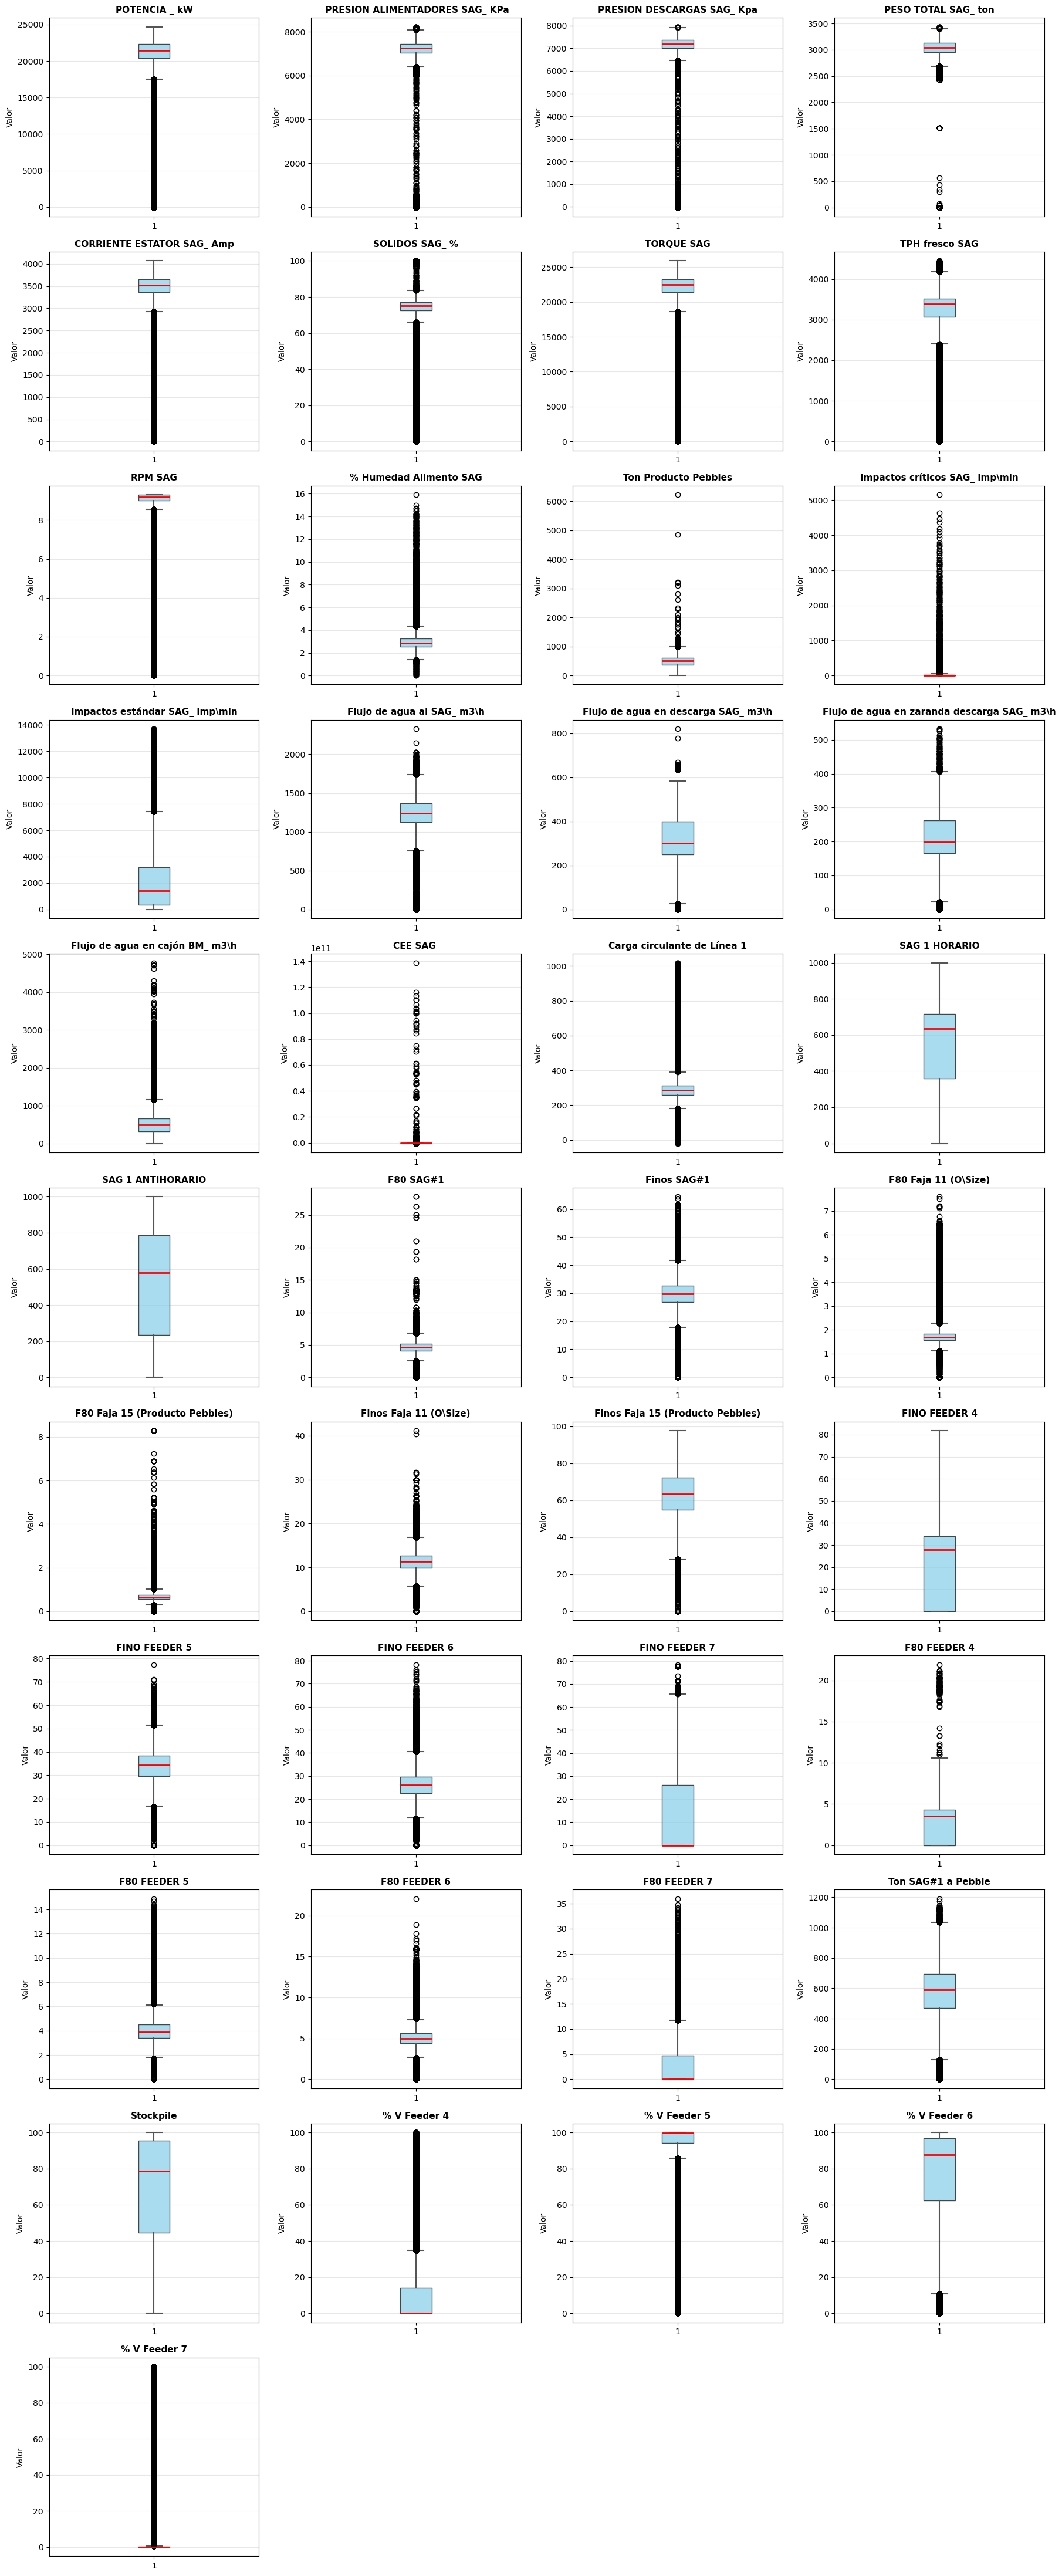


Estadísticas resumidas por variable:
                                                count          mean  \
POTENCIA _ kW                                551068.0  1.978971e+04   
 PRESION ALIMENTADORES SAG_ KPa              555576.0  7.099431e+03   
PRESION DESCARGAS SAG_ Kpa                   555576.0  7.049731e+03   
PESO TOTAL SAG_ ton                          551069.0  3.030193e+03   
CORRIENTE ESTATOR SAG_ Amp                   550982.0  3.249433e+03   
SOLIDOS SAG_ %                               555577.0  7.260242e+01   
TORQUE SAG                                   529468.0  2.066462e+04   
TPH fresco SAG                               571254.0  2.960012e+03   
RPM SAG                                      551068.0  8.419743e+00   
% Humedad Alimento SAG                       506427.0  2.980420e+00   
Ton Producto Pebbles                         570990.0  4.594942e+02   
Impactos críticos SAG_ imp\min               551596.0  1.503796e+01   
Impactos estándar SAG_ imp\min         

In [6]:
# Boxplots para todas las variables numéricas (excepto fecha)

# Obtener columnas numéricas (excluyendo datetime)
columnas_numericas = df.select_dtypes(include=[np.number]).columns.tolist()

print(f"Total de variables numéricas: {len(columnas_numericas)}")
print(f"Variables: {columnas_numericas}\n")

# Crear subplots
n_cols = 4  # 4 gráficos por fila
n_rows = (len(columnas_numericas) + n_cols - 1) // n_cols  # Calcular filas necesarias

fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 4*n_rows))
axes = axes.flatten()  # Convertir a array 1D

# Crear un boxplot para cada columna numérica
for idx, col in enumerate(columnas_numericas):
    ax = axes[idx]
    
    # Boxplot
    bp = ax.boxplot(df[col].dropna(), vert=True, patch_artist=True)
    
    # Estilo
    for patch in bp['boxes']:
        patch.set_facecolor('#87CEEB')
        patch.set_alpha(0.7)
    
    for whisker in bp['whiskers']:
        whisker.set(linewidth=1.5, color='#555')
    
    for cap in bp['caps']:
        cap.set(linewidth=1.5, color='#555')
    
    for median in bp['medians']:
        median.set(linewidth=2, color='red')
    
    ax.set_title(f'{col}', fontsize=11, fontweight='bold')
    ax.set_ylabel('Valor', fontsize=10)
    ax.grid(True, alpha=0.3, axis='y')

# Eliminar subplots vacíos
for idx in range(len(columnas_numericas), len(axes)):
    fig.delaxes(axes[idx])

plt.tight_layout()
plt.show()

print("\n" + "="*70)
print("Estadísticas resumidas por variable:")
print("="*70)
print(df[columnas_numericas].describe().T)

In [7]:
# Filtrar registros dentro del rango intercuartil para variables TPH

# Obtener las columnas que contienen "TPH"
columnas_TPH = [col for col in df.columns if "TPH" in col]

print(f"Columnas con 'TPH': {columnas_TPH}")
print("\n" + "="*70)

# Crear máscara para mantener solo registros dentro del IQR para TODAS las columnas TPH
mask_dentro = pd.Series([True] * len(df), index=df.index)

for col in columnas_TPH:
    # Calcular Q1, Q3 e IQR
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    
    # Definir límites
    limite_inferior = Q1 - 1.5 * IQR
    limite_superior = Q3 + 1.5 * IQR
    
    # Contar outliers
    outliers_en_col = ((df[col] < limite_inferior) | (df[col] > limite_superior)).sum()
    
    print(f"\n {col}:")
    print(f"   - Q1: {Q1:.2f}, Q3: {Q3:.2f}, IQR: {IQR:.2f}")
    print(f"   - Rango válido: [{limite_inferior:.2f}, {limite_superior:.2f}]")
    print(f"   - Outliers: {outliers_en_col}")
    
    # Actualizar máscara
    mask_dentro = mask_dentro & ((df[col] >= limite_inferior) & (df[col] <= limite_superior))

# Aplicar filtro
df_filtrado_tph = df[mask_dentro].copy()

print("\n" + "="*70)
print("RESUMEN DE FILTRADO:")
print("="*70)
print(f"Filas originales:     {len(df)}")
print(f"Filas después filtro: {len(df_filtrado_tph)}")
print(f"Filas removidas:      {len(df) - len(df_filtrado_tph)} ({(len(df) - len(df_filtrado_tph))/len(df)*100:.2f}%)")
print("="*70)

Columnas con 'TPH': ['TPH fresco SAG']


 TPH fresco SAG:
   - Q1: 3069.11, Q3: 3516.96, IQR: 447.85
   - Rango válido: [2397.33, 4188.73]
   - Outliers: 80157

RESUMEN DE FILTRADO:
Filas originales:     571320
Filas después filtro: 491097
Filas removidas:      80223 (14.04%)


In [8]:
df_filtrado_pot = df_filtrado_tph.copy()

In [9]:
# Limpieza de 'POTENCIA _ kW' por Rango Intercuartil en df_filtrado_pot

columna_potencia = 'POTENCIA _ kW'

# Verificar que la columna existe
if columna_potencia in df_filtrado_pot.columns:
    print(f"Limpiando columna: {columna_potencia}")
    print("=" * 70)
    
    # Calcular estadísticos
    Q1 = df_filtrado_pot[columna_potencia].quantile(0.25)
    Q3 = df_filtrado_pot[columna_potencia].quantile(0.75)
    IQR = Q3 - Q1
    
    # Definir límites (factor de Tukey = 1.5)
    limite_inferior = Q1 - 1.5 * IQR
    limite_superior = Q3 + 1.5 * IQR
    
    # Identificar outliers
    outliers_mask = (df_filtrado_pot[columna_potencia] < limite_inferior) | (df_filtrado_pot[columna_potencia] > limite_superior)
    num_outliers = outliers_mask.sum()
    
    # Mostrar información detallada
    print(f"\n Estadísticos de {columna_potencia}:")
    print(f"   - Mínimo:           {df_filtrado_pot[columna_potencia].min():.4f}")
    print(f"   - Q1 (25%):         {Q1:.4f}")
    print(f"   - Mediana (50%):    {df_filtrado_pot[columna_potencia].median():.4f}")
    print(f"   - Q3 (75%):         {Q3:.4f}")
    print(f"   - Máximo:           {df_filtrado_pot[columna_potencia].max():.4f}")
    print(f"   - IQR:              {IQR:.4f}")
    
    print(f"\n Límites del Rango Intercuartil (1.5×IQR):")
    print(f"   - Límite inferior:  {limite_inferior:.4f}")
    print(f"   - Límite superior:  {limite_superior:.4f}")
    
    print(f"\n  Outliers detectados: {num_outliers} ({num_outliers/len(df_filtrado_pot)*100:.2f}%)")
    
    # Mostrar ejemplos de valores removidos
    if num_outliers > 0:
        outliers_valores = df_filtrado_pot[outliers_mask][columna_potencia].sort_values()
        print(f"\n Valores de outliers a remover:")
        print(f"   - Valores bajos (< {limite_inferior:.4f}): {(outliers_valores < limite_inferior).sum()}")
        print(f"   - Valores altos (> {limite_superior:.4f}): {(outliers_valores > limite_superior).sum()}")
        print(f"   - Rango de outliers: [{outliers_valores.min():.4f}, {outliers_valores.max():.4f}]")
    
    # Limpiar el dataframe
    df_filtrado_pot = df_filtrado_pot[~outliers_mask].copy()
    
    print(f"\n Resumen de limpieza:")
    print(f"   - Filas originales:     {len(df_filtrado_pot) + num_outliers}")
    print(f"   - Filas después:        {len(df_filtrado_pot)}")
    print(f"   - Filas removidas:      {num_outliers} ( {num_outliers/len(df_filtrado_pot)*100:.2f}%)")
    print("\n" + "=" * 70)
    print("✓ Limpieza completada. df_filtrado_pot actualizado.")
else:
    print(f" Error: La columna '{columna_potencia}' no existe en el dataframe")
    print(f"Columnas disponibles: {list(df_filtrado_pot.columns)}")

Limpiando columna: POTENCIA _ kW

 Estadísticos de POTENCIA _ kW:
   - Mínimo:           -44.1233
   - Q1 (25%):         20730.2954
   - Mediana (50%):    21607.8503
   - Q3 (75%):         22424.5027
   - Máximo:           24685.3235
   - IQR:              1694.2073

 Límites del Rango Intercuartil (1.5×IQR):
   - Límite inferior:  18188.9844
   - Límite superior:  24965.8137

  Outliers detectados: 6233 (1.27%)

 Valores de outliers a remover:
   - Valores bajos (< 18188.9844): 6233
   - Valores altos (> 24965.8137): 0
   - Rango de outliers: [-44.1233, 18188.9728]

 Resumen de limpieza:
   - Filas originales:     491097
   - Filas después:        484864
   - Filas removidas:      6233 ( 1.29%)

✓ Limpieza completada. df_filtrado_pot actualizado.


In [10]:
df_filtrado_pot.describe(include='number').T

,count,mean,std,min,25%,50%,75%,max
POTENCIA _ kW,484805.0,21553.701702,1184.141633,1.818905e+04,20770.450563,21628.005664,22435.101449,24685.323454
PRESION ALIMENTADORES SAG_ KPa,484838.0,7260.966838,289.727745,0.000000e+00,7069.819458,7288.898741,7461.660334,8201.756535
PRESION DESCARGAS SAG_ Kpa,484838.0,7215.417913,248.092711,0.000000e+00,7055.572142,7230.905807,7377.574442,7940.068608
PESO TOTAL SAG_ ton,484805.0,3049.271879,120.493541,2.638242e+03,2967.420239,3059.936934,3133.981539,3429.996419
CORRIENTE ESTATOR SAG_ Amp,480941.0,3526.088888,187.213200,2.687086e+03,3409.736802,3539.802686,3659.208496,4050.138672
SOLIDOS SAG_ %,484838.0,74.831653,2.629172,5.998721e+01,72.996272,75.271968,76.995440,100.000000
TORQUE SAG,463953.0,22486.871435,1171.132546,1.867345e+04,21747.785352,22599.683903,23336.598177,25674.577067
TPH fresco SAG,484864.0,3379.383987,268.587881,2.397366e+03,3263.793183,3432.980022,3538.754346,4188.728849
RPM SAG,484805.0,9.154453,0.193136,7.249231e+00,9.069560,9.239951,9.299621,9.304526
% Humedad Alimento SAG,483949.0,2.966938,0.707854,1.496028e+00,2.520493,2.847895,3.250367,15.910523


Columnas TPH encontradas: ['TPH fresco SAG']

Datos para últimos 30 días:
  Fecha inicio: 2020-01-31 23:59:00
  Fecha fin:    2020-03-31 23:59:00
  Total registros: 62492
  Graficando: ['TPH fresco SAG']


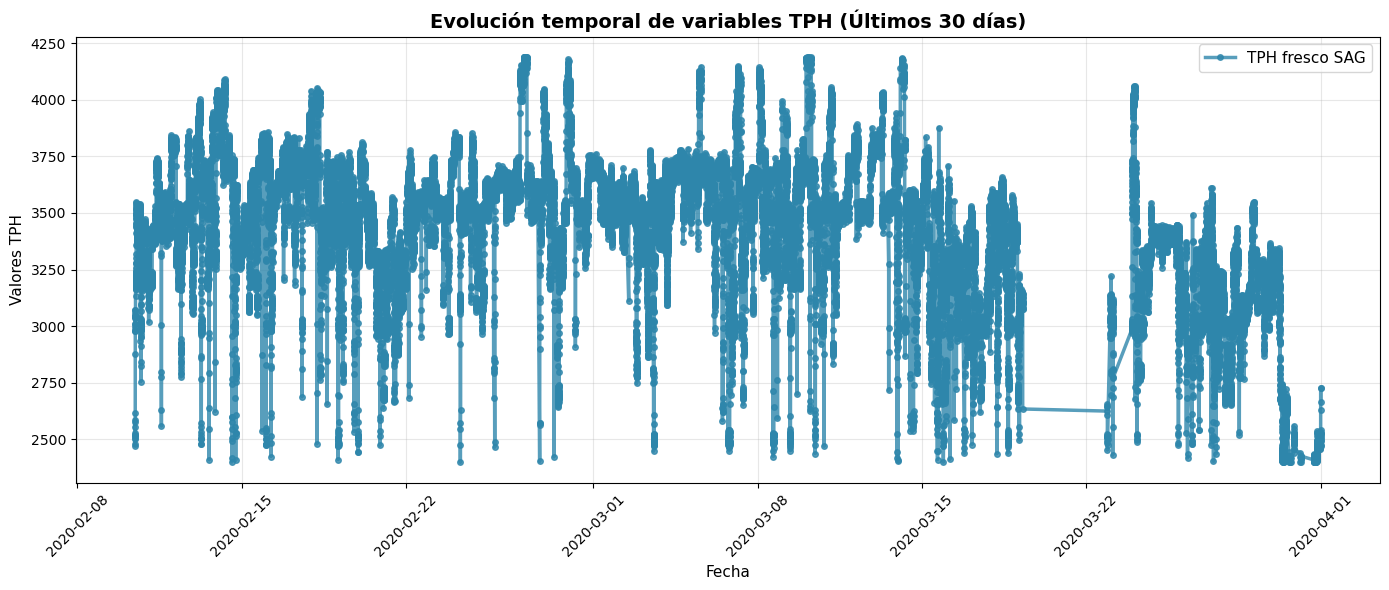


ESTADÍSTICAS DE VARIABLES TPH (últimos 30 días)
                  count         mean         std         min          25%  \
TPH fresco SAG  62492.0  3445.896509  293.182409  2397.58232  3293.259017   

                        50%          75%          max  
TPH fresco SAG  3497.696223  3644.914606  4188.728849  


In [11]:
# Gráfica Time Series: Fecha vs TPH (solo últimos 30 días)

# Obtener columnas con fecha
fecha_columns = [col for col in df_filtrado_pot.columns if "fecha" in col.lower()]

# Identificar la columna de fecha
fecha_col = fecha_columns[0] if fecha_columns else None

# Obtener columnas con TPH
columnas_tph = [col for col in df_filtrado_pot.columns if "TPH" in col]

print(f"Columnas TPH encontradas: {columnas_tph}")

if fecha_col and columnas_tph:
    # Ordenar por fecha y filtrar últimos 30 días
    df_plot = df_filtrado_pot.sort_values(by=fecha_col).copy()
    
    # Calcular fecha máxima y restar 30 días
    fecha_max = df_plot[fecha_col].max()
    fecha_min = fecha_max - pd.Timedelta(days=60)
    
    # Filtrar datos de últimos 30 días
    df_plot = df_plot[(df_plot[fecha_col] >= fecha_min) & (df_plot[fecha_col] <= fecha_max)]
    
    print(f"\nDatos para últimos 30 días:")
    print(f"  Fecha inicio: {fecha_min}")
    print(f"  Fecha fin:    {fecha_max}")
    print(f"  Total registros: {len(df_plot)}")
    
    # Usar solo las dos primeras columnas TPH
    columnas_a_graficar = columnas_tph[:2] if len(columnas_tph) >= 2 else columnas_tph
    print(f"  Graficando: {columnas_a_graficar}")
    
    # Crear figura
    fig, ax = plt.subplots(figsize=(14, 6))
    
    # Colores para cada línea
    colores = ['#2E86AB', '#A23B72']
    
    # Plotear columnas TPH
    for idx, col_tph in enumerate(columnas_a_graficar):
        color = colores[idx]
        ax.plot(df_plot[fecha_col], df_plot[col_tph], 
                linewidth=2.5, color=color, alpha=0.8, marker='o', markersize=4, label=col_tph)
    
    # Estilo
    ax.set_title('Evolución temporal de variables TPH (Últimos 30 días)', fontsize=14, fontweight='bold')
    ax.set_xlabel(f'{fecha_col}', fontsize=11)
    ax.set_ylabel('Valores TPH', fontsize=11)
    ax.grid(True, alpha=0.3)
    ax.legend(loc='best', fontsize=11)
    
    # Rotar etiquetas del eje X
    ax.tick_params(axis='x', rotation=45)
    plt.tight_layout()
    plt.show()
    
    print("\n" + "=" * 70)
    print("ESTADÍSTICAS DE VARIABLES TPH (últimos 30 días)")
    print("=" * 70)
    print(df_plot[columnas_a_graficar].describe().T)
else:
    print(" Error: No se encontró columna de fecha o columnas TPH")
    print(f"Fecha: {fecha_col}")
    print(f"TPH: {columnas_tph}")

Correlación con 'TPH fresco SAG':
 TPH fresco SAG                                 1.000000
CEE SAG                                        0.837182
SOLIDOS SAG_ %                                 0.447323
% V Feeder 6                                   0.384139
% Humedad Alimento SAG                         0.309746
Finos SAG#1                                    0.251136
Flujo de agua en zaranda descarga SAG_ m3\h    0.223518
Carga circulante de Línea 1                    0.221440
Finos Faja 15 (Producto Pebbles)               0.204810
F80 SAG#1                                      0.194435
F80 FEEDER 5                                   0.183635
Ton Producto Pebbles                           0.176122
Stockpile                                      0.175456
F80 Faja 15 (Producto Pebbles)                 0.168363
FINO FEEDER 5                                  0.165612
FINO FEEDER 6                                  0.164150
% V Feeder 4                                   0.161529
Ton SAG#1 a P

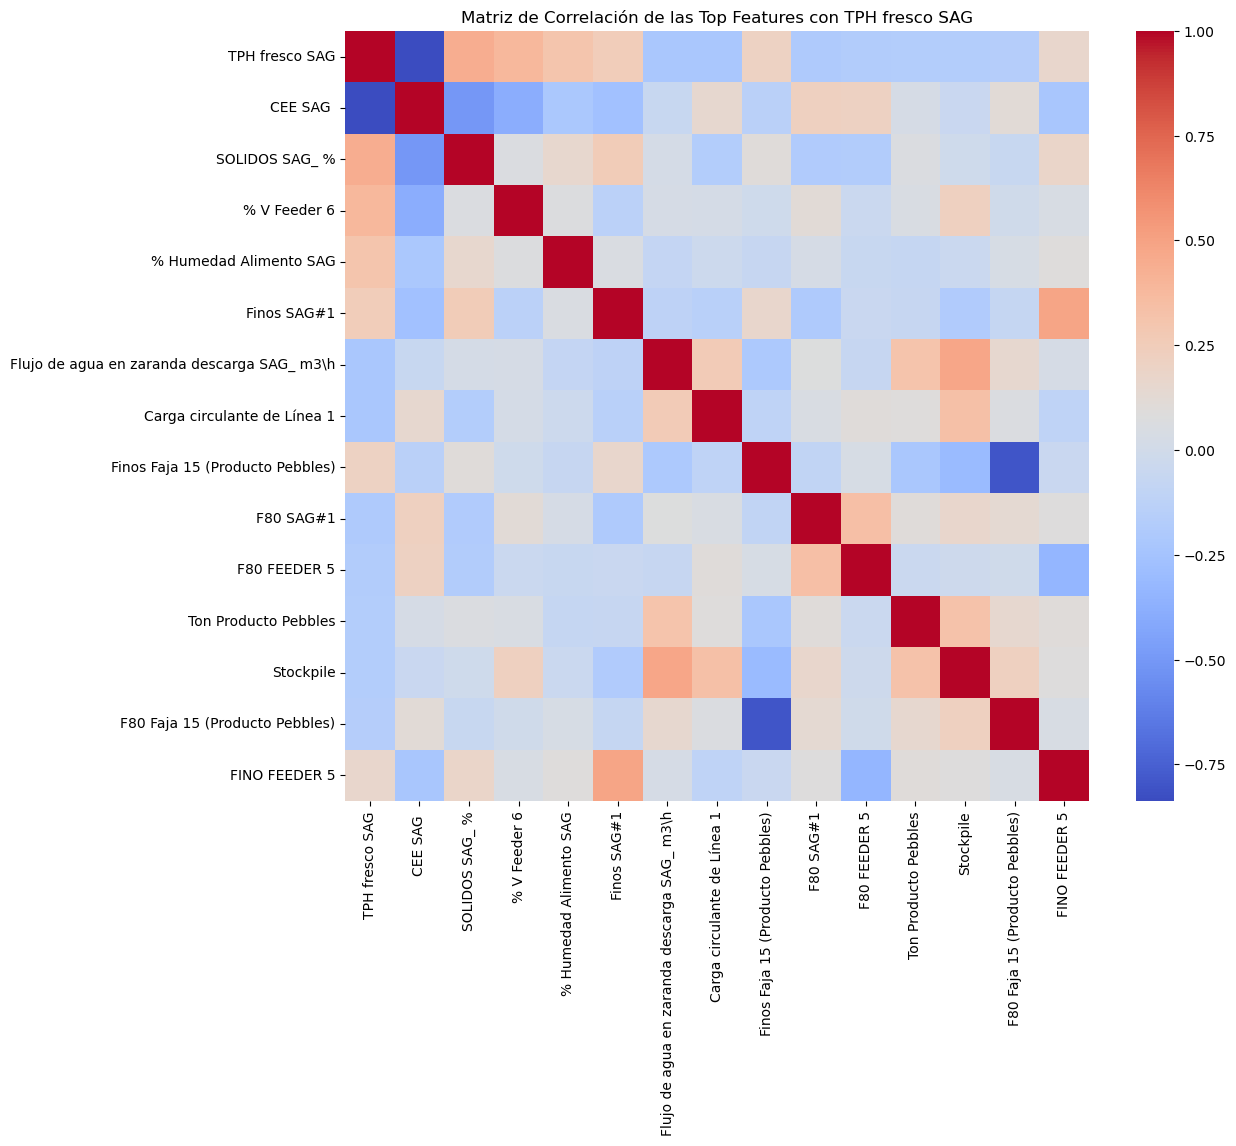

In [12]:
# Drop the 'Fecha' column as it's a datetime object and not suitable for correlation with numerical features.
df_numeric = df_filtrado_pot.drop(columns=['Fecha'])

# Calculate the correlation matrix
correlation_matrix = df_numeric.corr(method='pearson')

# Get correlations with the target variable 'TPH fresco SAG'
#tph_fresco_sag_corr = correlation_matrix['TPH fresco SAG'].sort_values(ascending=False)
tph_fresco_sag_corr = correlation_matrix['TPH fresco SAG'].abs().sort_values(ascending=False)

print("Correlación con 'TPH fresco SAG':\n", tph_fresco_sag_corr)

top_n_features = 15 # You can adjust this number
#top_correlated_features = tph_fresco_sag_corr.head(top_n_features).index.tolist() + \
#                           tph_fresco_sag_corr.tail(top_n_features).index.tolist()
top_correlated_features = tph_fresco_sag_corr.head(top_n_features).index.tolist()
# Ensure 'TPH fresco SAG' is in the list for context
if 'TPH fresco SAG' not in top_correlated_features:
    top_correlated_features.append('TPH fresco SAG')

# Filter the original DataFrame for these features
df_top_corr = df_filtrado_pot[top_correlated_features]

plt.figure(figsize=(12, 10))
#sns.heatmap(df_top_corr.corr(), annot=True, cmap='coolwarm', fmt=".2f")
sns.heatmap(df_top_corr.corr(), annot=False, cmap='coolwarm')
plt.title('Matriz de Correlación de las Top Features con TPH fresco SAG')
plt.show()

In [13]:
print(df_filtrado_pot.columns)

Index(['Fecha', 'POTENCIA _ kW', ' PRESION ALIMENTADORES SAG_ KPa',
       'PRESION DESCARGAS SAG_ Kpa', 'PESO TOTAL SAG_ ton',
       'CORRIENTE ESTATOR SAG_ Amp', 'SOLIDOS SAG_ %', 'TORQUE SAG',
       'TPH fresco SAG', 'RPM SAG', '% Humedad Alimento SAG',
       'Ton Producto Pebbles', 'Impactos críticos SAG_ imp\min',
       'Impactos estándar SAG_ imp\min', 'Flujo de agua al SAG_ m3\h',
       'Flujo de agua en descarga SAG_ m3\h',
       'Flujo de agua en zaranda descarga SAG_ m3\h',
       'Flujo de agua en cajón BM_ m3\h', 'CEE SAG ',
       'Carga circulante de Línea 1', 'SAG 1 HORARIO', 'SAG 1 ANTIHORARIO',
       'F80 SAG#1', 'Finos SAG#1', 'F80 Faja 11 (O\Size)',
       'F80 Faja 15 (Producto Pebbles)', 'Finos Faja 11 (O\Size)',
       'Finos Faja 15 (Producto Pebbles)', 'FINO FEEDER 4', 'FINO FEEDER 5',
       'FINO FEEDER 6', 'FINO FEEDER 7', 'F80 FEEDER 4', 'F80 FEEDER 5',
       'F80 FEEDER 6', 'F80 FEEDER 7', 'Ton SAG#1 a Pebble', 'Stockpile',
       '% V Feeder 4', '%

## Selección de Features

En base a la exploración previa de datos, seleccionaremos las variables manipulables, más relevantes para nuestro modelo. 

In [14]:
# Selección de Features
features_seleccionadas = ['TPH fresco SAG', 'CEE SAG ', 'SOLIDOS SAG_ %', '% V Feeder 4', '% V Feeder 5', '% V Feeder 6', '% V Feeder 7', 'Finos SAG#1', 'F80 SAG#1', ' PRESION ALIMENTADORES SAG_ KPa']
df_clean = df_filtrado_pot[features_seleccionadas].copy()
print(df_clean.head())

   TPH fresco SAG  CEE SAG   SOLIDOS SAG_ %  % V Feeder 4  % V Feeder 5  \
0     3480.590445  6.565282       75.141449           5.8          99.9   
1     3495.946182  6.543910       74.515007           5.8          99.8   
2     3484.942773  6.574383       74.691086           5.8          99.8   
3     3496.260614  6.556828       75.124451           5.8          99.9   
4     3509.473818  6.517532       74.919861           5.7          99.7   

   % V Feeder 6  % V Feeder 7  Finos SAG#1  F80 SAG#1  \
0          96.3           0.1    36.240448   5.645689   
1          96.9           0.1    36.240448   5.645689   
2          97.7           0.1    36.240448   5.645689   
3          97.4           0.1    36.240448   5.645689   
4          97.8           0.1    36.240448   5.645689   

    PRESION ALIMENTADORES SAG_ KPa  
0                      7442.802795  
1                      7450.330352  
2                      7448.179272  
3                      7453.894749  
4                    

## creation features

In [15]:
# ==================== FUNCIÓN DE INGENIERÍA DE CARACTERÍSTICAS MEJORADA ====================

def crear_features_mejoradas(df, fecha_col='Fecha', target_col='TPH fresco SAG'):
    """
    Genera características cíclicas, rezagos y promedios/estándares móviles para series por MINUTO.
    
    Parámetros:
    -----------
    df : pandas.DataFrame
        Dataframe con datos por minuto
    fecha_col : str
        Nombre de la columna datetime
    target_col : str
        Nombre de la columna objetivo/variable principal
        
    Retorna:
    --------
    pandas.DataFrame
        DataFrame con feature engineering y datos limpios (sin NaN)
    """
    
    print("Creando features mejoradas para datos por minuto...")
    print("=" * 70)
    
    # Hacer una copia para no modificar el original
    df = df.copy()
    
    # Establecer índice como datetime
    if fecha_col in df.columns:
        df[fecha_col] = pd.to_datetime(df[fecha_col])
        df = df.set_index(fecha_col)
        print(f"\n Índice establecido como: {fecha_col}")
    
    # Remover NaN generados por lags y rolling windows
    initial_rows = len(df)
    df = df.dropna()
    final_rows = len(df)
    removed_rows = initial_rows - final_rows
    
    print("\n" + "=" * 70)
    print("RESUMEN DE FEATURES CREADAS:")
    print("=" * 70)
    print(f"Filas iniciales:  {initial_rows:,}")
    print(f"Filas finales:    {final_rows:,}")
    print(f"Filas removidas:  {removed_rows:,} ({removed_rows/initial_rows*100:.2f}%)")
    print(f"\nTotal de columnas: {len(df.columns)}")
    print(f"Nuevas columnas de features:\n{[col for col in df.columns if col not in ['Fecha']]}")
    
    return df

# Aplicar la función
print("\nAPLICANDO FUNCIÓN DE INGENIERÍA DE CARACTERÍSTICAS")
print("=" * 70)
df_features = crear_features_mejoradas(df_clean, 
                                       fecha_col='Fecha', 
                                       target_col='TPH fresco SAG')

print("\n Dataframe con features listo")
print(f"\nPrimeras filas:")
print(df_features.head())


APLICANDO FUNCIÓN DE INGENIERÍA DE CARACTERÍSTICAS
Creando features mejoradas para datos por minuto...

RESUMEN DE FEATURES CREADAS:
Filas iniciales:  484,864
Filas finales:    484,801
Filas removidas:  63 (0.01%)

Total de columnas: 10
Nuevas columnas de features:
['TPH fresco SAG', 'CEE SAG ', 'SOLIDOS SAG_ %', '% V Feeder 4', '% V Feeder 5', '% V Feeder 6', '% V Feeder 7', 'Finos SAG#1', 'F80 SAG#1', ' PRESION ALIMENTADORES SAG_ KPa']

 Dataframe con features listo

Primeras filas:
   TPH fresco SAG  CEE SAG   SOLIDOS SAG_ %  % V Feeder 4  % V Feeder 5  \
0     3480.590445  6.565282       75.141449           5.8          99.9   
1     3495.946182  6.543910       74.515007           5.8          99.8   
2     3484.942773  6.574383       74.691086           5.8          99.8   
3     3496.260614  6.556828       75.124451           5.8          99.9   
4     3509.473818  6.517532       74.919861           5.7          99.7   

   % V Feeder 6  % V Feeder 7  Finos SAG#1  F80 SAG#1  \
0

In [16]:
df_features.head()

,TPH fresco SAG,CEE SAG,SOLIDOS SAG_ %,% V Feeder 4,% V Feeder 5,% V Feeder 6,% V Feeder 7,Finos SAG#1,F80 SAG#1,PRESION ALIMENTADORES SAG_ KPa
0,3480.590445,6.565282,75.141449,5.8,99.9,96.3,0.1,36.240448,5.645689,7442.802795
1,3495.946182,6.543910,74.515007,5.8,99.8,96.9,0.1,36.240448,5.645689,7450.330352
2,3484.942773,6.574383,74.691086,5.8,99.8,97.7,0.1,36.240448,5.645689,7448.179272
3,3496.260614,6.556828,75.124451,5.8,99.9,97.4,0.1,36.240448,5.645689,7453.894749
4,3509.473818,6.517532,74.919861,5.7,99.7,97.8,0.1,36.240448,5.645689,7461.798114


TPH fresco SAG
CEE SAG 
SOLIDOS SAG_ %
% V Feeder 4
% V Feeder 5
% V Feeder 6
% V Feeder 7
Finos SAG#1
F80 SAG#1
 PRESION ALIMENTADORES SAG_ KPa


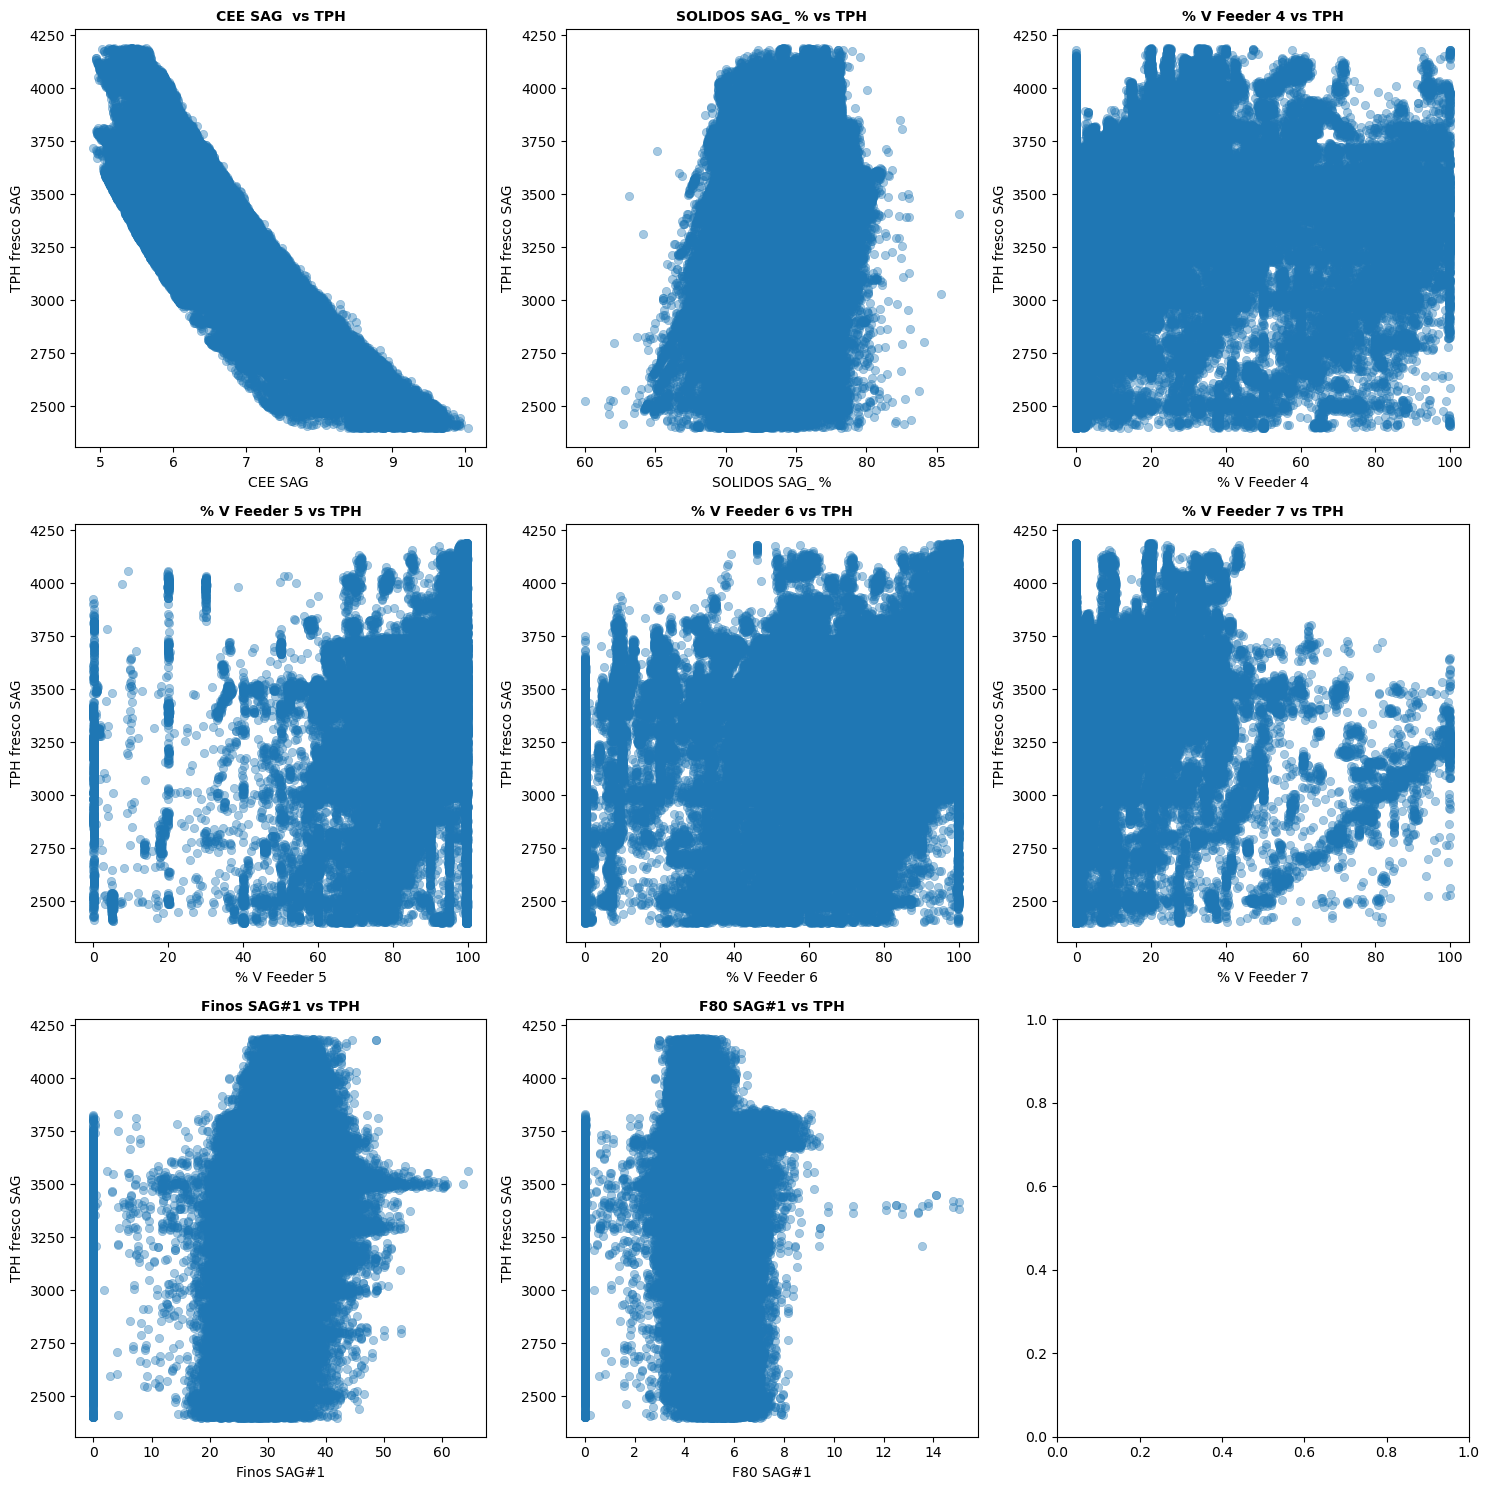

In [17]:
# Scatter plot de TPH fresco SAG vs todas las features

fig, axes = plt.subplots(3, 3, figsize=(15, 15))
axes = axes.flatten()
for i, feature in enumerate(df_features.columns):
    print(feature)
    if feature != 'TPH fresco SAG' and i < len(axes):
        sns.scatterplot(data=df_features, x=feature, y='TPH fresco SAG', alpha=0.4, edgecolor=None, ax=axes[i-1])
        axes[i-1].set_title(f'{feature} vs TPH', fontsize=10, fontweight='bold')
        axes[i-1].set_xlabel(feature)
        axes[i-1].set_ylabel('TPH fresco SAG')
    elif feature == 'TPH fresco SAG':
        i = i - 1

plt.tight_layout()
plt.show()

In [18]:
df_features.describe().T

,count,mean,std,min,25%,50%,75%,max
TPH fresco SAG,484801.0,3379.398746,268.540623,2397.366172,3263.813712,3432.975146,3538.732552,4188.728849
CEE SAG,484801.0,6.423835,0.689433,4.909864,5.968065,6.277129,6.707179,10.031668
SOLIDOS SAG_ %,484801.0,74.829950,2.621053,59.987210,72.996162,75.271660,76.995273,86.576256
% V Feeder 4,484801.0,12.118224,19.175957,0.000000,0.100000,3.900000,16.100000,100.000000
% V Feeder 5,484801.0,96.660950,9.555433,0.000000,99.700000,99.800000,99.800000,100.000000
% V Feeder 6,484801.0,83.620793,20.756299,0.000000,78.000000,91.200000,97.900000,100.000000
% V Feeder 7,484801.0,3.912252,9.738627,0.000000,0.000000,0.100000,2.000000,100.000000
Finos SAG#1,484801.0,30.571871,4.904888,0.000000,28.093988,30.540520,33.224651,64.465781
F80 SAG#1,484801.0,4.749344,0.834433,0.000000,4.307514,4.732285,5.209118,15.023779
PRESION ALIMENTADORES SAG_ KPa,484801.0,7261.460156,283.476235,6339.606370,7069.852759,7288.918683,7461.667295,8201.756535


## entrenamiento

In [ ]:
# ==================== ENTRENAMIENTO DEL MODELO ====================

print("ENTRENAMIENTO DEL MODELO DE PREDICCIÓN")
print("=" * 70)


# Los features ya fueron creados en la celda anterior
print(f"\n Dataframe con features: {df_features.shape}")
print(f"  Filas: {df_features.shape[0]:,}")
print(f"  Columnas: {df_features.shape[1]}")

# Definir variable objetivo
target_col = 'TPH fresco SAG'

# Verificar que la columna existe
if target_col in df_features.columns:
    print(f"\n Variable objetivo: {target_col}")
    
    # Definir X (features) e y (target)
    X = df_features.drop(columns=[target_col,'TPH_fresco_SAG_lag_1min'])
    y = df_features[target_col]
    
    print(f" X shape: {X.shape}")
    print(f" y shape: {y.shape}")
    
    # Separar en train/test (shuffle=False es CRÍTICO para series de tiempo)
    print("\n" + "=" * 70)
    print("DIVISIÓN TRAIN/TEST (sin shuffle - preserva orden temporal)")
    print("=" * 70)
    
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, shuffle=False
    )
    
    print(f"\n Conjunto de entrenamiento:")
    print(f"  - X_train shape: {X_train.shape}")
    print(f"  - y_train shape: {y_train.shape}")
    print(f"\n Conjunto de prueba:")
    print(f"  - X_test shape: {X_test.shape}")
    print(f"  - y_test shape: {y_test.shape}")
    
    # Entrenar el modelo
    print("\n" + "=" * 70)
    print("ENTRENAMIENTO DEL MODELO")
    print("=" * 70)
    print("\nConfigurando RandomForestRegressor...")
    print("  - n_estimators: 300 (300 árboles)")
    print("  - max_depth: 15 (profundidad máxima)")
    print("  - random_state: 42 (reproducibilidad)")
    print("  - n_jobs: -1 (usar todos los cores)")
    
    model = RandomForestRegressor(
        n_estimators=300,
        max_depth=15,
        random_state=42,
        n_jobs=-1,
        verbose=1
    )
    
    print("\nEntrenando el modelo...")
    import time
    start_time = time.time()
    model.fit(X_train, y_train)
    training_time = time.time() - start_time
    
    print(f" Modelo entrenado en {training_time:.2f} segundos")
else:
    print(f" Error: La columna '{target_col}' no existe en df_features")
    print(f"Columnas disponibles: {list(df_features.columns)}")

ENTRENAMIENTO DEL MODELO DE PREDICCIÓN

 Dataframe con features: (270835, 55)
  Filas: 270,835
  Columnas: 55

 Variable objetivo: TPH fresco SAG
 X shape: (270835, 53)
 y shape: (270835,)

DIVISIÓN TRAIN/TEST (sin shuffle - preserva orden temporal)

 Conjunto de entrenamiento:
  - X_train shape: (216668, 53)
  - y_train shape: (216668,)

 Conjunto de prueba:
  - X_test shape: (54167, 53)
  - y_test shape: (54167,)

ENTRENAMIENTO DEL MODELO

Configurando RandomForestRegressor...
  - n_estimators: 300 (300 árboles)
  - max_depth: 15 (profundidad máxima)
  - random_state: 42 (reproducibilidad)
  - n_jobs: -1 (usar todos los cores)

Entrenando el modelo...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  6.8min


 Modelo entrenado en 627.83 segundos


[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 10.5min finished


In [36]:
# Realizar predicciones
print("\n" + "=" * 70)
print("EVALUACIÓN DEL MODELO")
print("=" * 70)

print("\nRealizando predicciones en conjunto de prueba...")
y_pred = model.predict(X_test)
print(f" Predicciones realizadas: {len(y_pred)}")

# Calcular métricas
print("\nCalculando métricas de desempeño...")
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

# Calcular MAPE (Mean Absolute Percentage Error)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

print("\n" + "=" * 70)
print("RESULTADOS DEL MODELO")
print("=" * 70)
print(f"\n MÉTRICAS DE DESEMPEÑO:")
print(f"  - R_2 Score:           {r2:.4f}")
print(f"  - MAE (Error Absoluto Medio): {mae:.4f}")
print(f"  - RMSE (Raíz del Error Cuadrático Medio): {rmse:.4f}")
print(f"  - MAPE (Error Porcentual):    {mape:.4f}%")

print(f"\n ESTADÍSTICAS DE PREDICCIÓN:")
print(f"  - y_test (min, max):  {y_test.min():.4f}, {y_test.max():.4f}")
print(f"  - y_pred (min, max):  {y_pred.min():.4f}, {y_pred.max():.4f}")
print(f"  - Diferencia promedio: {(y_pred - y_test).mean():.4f}")

# Importancia de features
print(f"\n TOP 10 FEATURES MÁS IMPORTANTES:")
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

print(feature_importance.head(10).to_string(index=False))

# Guardar métricas en diccionario
metricas_modelo = {
    'Modelo': 'RandomForestRegressor',
    'R²': f"{r2:.4f}",
    'MAE': f"{mae:.4f}",
    'RMSE': f"{rmse:.4f}",
    'MAPE': f"{mape:.4f}%",
    'Registros_Train': len(X_train),
    'Registros_Test': len(X_test),
    'Tiempo_Entrenamiento_seg': f"{training_time:.2f}"
}   


EVALUACIÓN DEL MODELO

Realizando predicciones en conjunto de prueba...


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.6s
[Parallel(n_jobs=8)]: Done 300 out of 300 | elapsed:    1.1s finished


 Predicciones realizadas: 54167

Calculando métricas de desempeño...

RESULTADOS DEL MODELO

 MÉTRICAS DE DESEMPEÑO:
  - R_2 Score:           0.9761
  - MAE (Error Absoluto Medio): 24.0319
  - RMSE (Raíz del Error Cuadrático Medio): 42.1336
  - MAPE (Error Porcentual):    0.6883%

 ESTADÍSTICAS DE PREDICCIÓN:
  - y_test (min, max):  2397.5823, 4133.9162
  - y_pred (min, max):  2409.1641, 4025.6325
  - Diferencia promedio: -0.1312

 TOP 10 FEATURES MÁS IMPORTANTES:
                    feature  importance
                   CEE SAG     0.652798
TPH_fresco_SAG_roll_mean_1h    0.248866
              POTENCIA _ kW    0.058399
               % V Feeder 6    0.013833
 TPH_fresco_SAG_roll_std_1h    0.008394
      TPH_fresco_SAG_lag_1h    0.001904
               % V Feeder 5    0.001477
                 TORQUE SAG    0.001388
               % V Feeder 4    0.001270
       Ton Producto Pebbles    0.000999


VISUALIZACIÓN DE PREDICCIONES

 Longitud de y_test: 54,167 puntos
 Longitud de y_pred: 54,167 puntos

Mostrando últimas 12 horas (60 minutos)...
 Datos filtrados a últimas 12 horas (60 puntos)


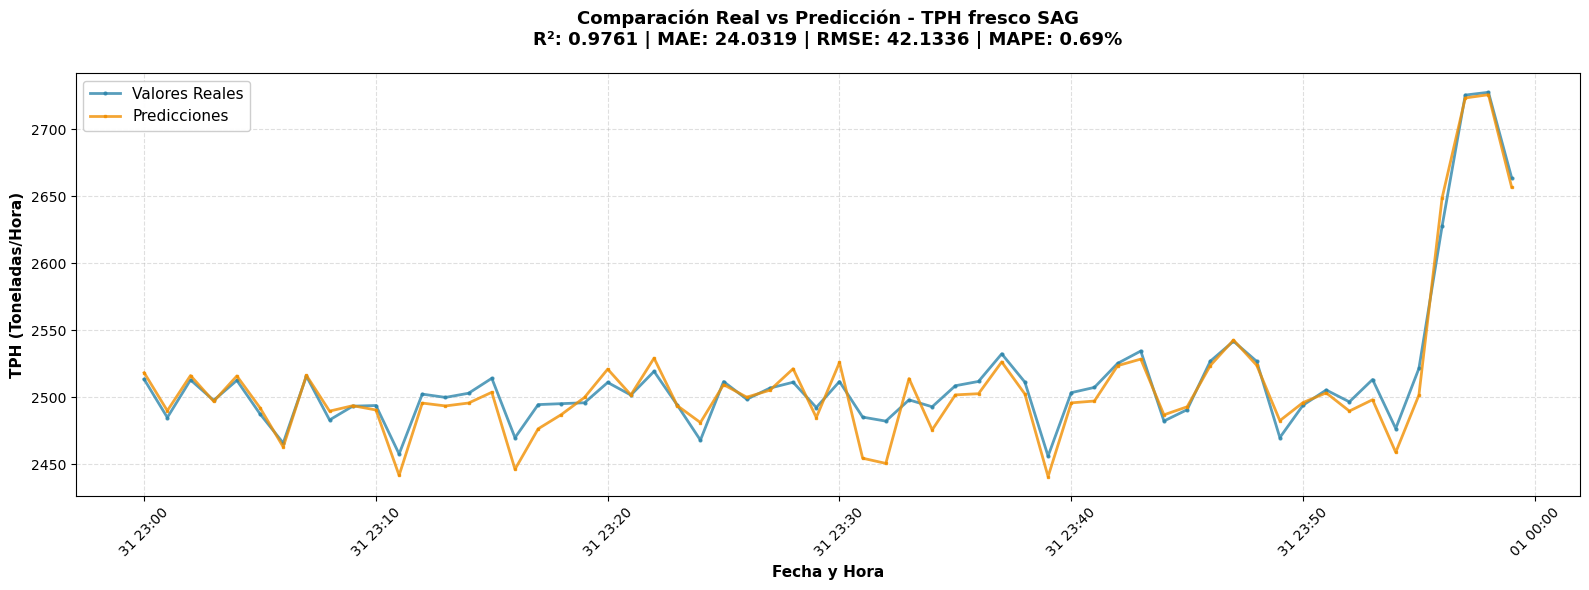


ANÁLISIS DE ERRORES

 Estadísticas de Error Absoluto:
  - Error mínimo:  0.0932
  - Error máximo:  31.5604
  - Error promedio: 8.2693
  - Error mediana:  6.6397
  - Desv. Estándar: 7.2222

 Precisión:
  - Predicciones dentro de ±12.02:  75.00%
  - Predicciones dentro de ±24.03:  96.67%


In [37]:
# ==================== VISUALIZACIÓN DE PREDICCIONES ====================

print("VISUALIZACIÓN DE PREDICCIONES")
print("=" * 70)

# Crear serie de predicciones con el mismo índice que y_test
y_pred_series = pd.Series(y_pred, index=y_test.index)

# Ordenar por índice (fecha)
y_pred_series = y_pred_series.sort_index()
y_test = y_test.sort_index()

print(f"\n Longitud de y_test: {len(y_test):,} puntos")
print(f" Longitud de y_pred: {len(y_pred_series):,} puntos")

# Calcular horas a mostrar (últimas 12 horas en minutos)
# Para datos por minuto: 1 hora = 60 minutos, 12 horas = 720 puntos
horas_a_mostrar = 1 * 60  # 720 puntos (12 horas)

print(f"\nMostrando últimas 12 horas ({horas_a_mostrar:,} minutos)...")

# Filtrar el último segmento
if len(y_test) > horas_a_mostrar:
    y_test_zoom = y_test.iloc[-horas_a_mostrar:]
    y_pred_zoom = y_pred_series.iloc[-horas_a_mostrar:]
    print(f" Datos filtrados a últimas 12 horas ({horas_a_mostrar:,} puntos)")
else:
    y_test_zoom = y_test
    y_pred_zoom = y_pred_series
    print(f"  Dataset menor a 12 horas, mostrando todo ({len(y_test):,} puntos)")

# Crear figura
fig, ax = plt.subplots(figsize=(16, 6))

# Plotear valores reales
ax.plot(y_test_zoom.index, y_test_zoom.values, 
        label='Valores Reales', color='#2E86AB', linewidth=2, alpha=0.8, marker='o', markersize=2)

# Plotear predicciones
ax.plot(y_pred_zoom.index, y_pred_zoom.values, 
        label='Predicciones', color='#F18F01', linewidth=2, alpha=0.8, marker='s', markersize=2)

# Título con métricas
titulo = f"Comparación Real vs Predicción - {target_col}\nR²: {r2:.4f} | MAE: {mae:.4f} | RMSE: {rmse:.4f} | MAPE: {mape:.2f}%"
ax.set_title(titulo, fontsize=13, fontweight='bold', pad=20)

# Etiquetas y estilos
ax.set_xlabel('Fecha y Hora', fontsize=11, fontweight='bold')
ax.set_ylabel('TPH (Toneladas/Hora)', fontsize=11, fontweight='bold')
ax.legend(loc='best', fontsize=11, framealpha=0.95)
ax.grid(True, linestyle='--', alpha=0.4)

# Rotar etiquetas del eje X
ax.tick_params(axis='x', rotation=45)

# Ajustar layout
plt.tight_layout()
plt.show()

# Calcular y mostrar error por punto
print("\n" + "=" * 70)
print("ANÁLISIS DE ERRORES")
print("=" * 70)

errores = np.abs(y_test_zoom.values - y_pred_zoom.values)
print(f"\n Estadísticas de Error Absoluto:")
print(f"  - Error mínimo:  {errores.min():.4f}")
print(f"  - Error máximo:  {errores.max():.4f}")
print(f"  - Error promedio: {errores.mean():.4f}")
print(f"  - Error mediana:  {np.median(errores):.4f}")
print(f"  - Desv. Estándar: {errores.std():.4f}")

# Porcentaje de predicciones dentro de rangos de error
dentro_5pct = np.sum(errores <= mae * 0.5) / len(errores) * 100
dentro_10pct = np.sum(errores <= mae) / len(errores) * 100

print(f"\n Precisión:")
print(f"  - Predicciones dentro de ±{mae*0.5:.2f}:  {dentro_5pct:.2f}%")
print(f"  - Predicciones dentro de ±{mae:.2f}:  {dentro_10pct:.2f}%")


# Entrenamiento con red neuronal 

In [41]:
# 1. PREPARACIÓN DE DATOS
# ========================
target_col = 'TPH fresco SAG'
X_raw = df_features.drop(columns=[target_col]) 
y_raw = df_features[target_col]

X_np = X_raw.values
y_np = y_raw.values.reshape(-1, 1) # Neural nets esperan forma (N, 1), no (N,)

X_train, X_test, y_train, y_test = train_test_split(X_np, y_np, test_size=0.2, random_state=42, shuffle=False)

# ESCALADO (StandardScaler) - ¡OBLIGATORIO PARA REDES NEURONALES!
scaler_X = StandardScaler()
scaler_y = StandardScaler() 

X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test) 
y_train_scaled = scaler_y.fit_transform(y_train)
y_test_scaled = scaler_y.transform(y_test)

# Convertir a Tensores de PyTorch 
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_scaled, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test_scaled, dtype=torch.float32)

# Crear DataLoaders (Para entrenar por lotes/batches en lugar de todo a la vez)
batch_size = 64
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [42]:
class SagMillNet(nn.Module):
    def __init__(self, input_size):
        super(SagMillNet, self).__init__()
        # Capa de entrada a Capa Oculta 1 (64 neuronas)
        self.layer1 = nn.Linear(input_size, 256)# try 256
        self.relu = nn.ReLU() # Función de activación (ayuda a aprender no-linealidades)
        
        # Capa Oculta 1 a Capa Oculta 2 (32 neuronas) # try 128
        self.layer2 = nn.Linear(256, 128)
        
        # Capa de Salida (1 neurona: Predicción del TPH)
        self.output = nn.Linear(128, 1) 
        
        # Dropout: Apaga neuronas al azar para evitar memorizar datos (overfitting)
        self.dropout = nn.Dropout(0.2) 
    def forward(self, x):
        x = self.layer1(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.layer2(x)
        x = self.relu(x)
        
        x = self.output(x)
        return x
# Inicializar modelo
input_features = X_train.shape[1] 
model = SagMillNet(input_features)
# Definir la función de pérdida (MSE para regresión) y el optimizador (Adam es el estándar)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001) # Learning rate

 Iniciando entrenamiento...
Época [10/30], Loss: 0.0460
Época [20/30], Loss: 0.0427
Época [30/30], Loss: 0.0409


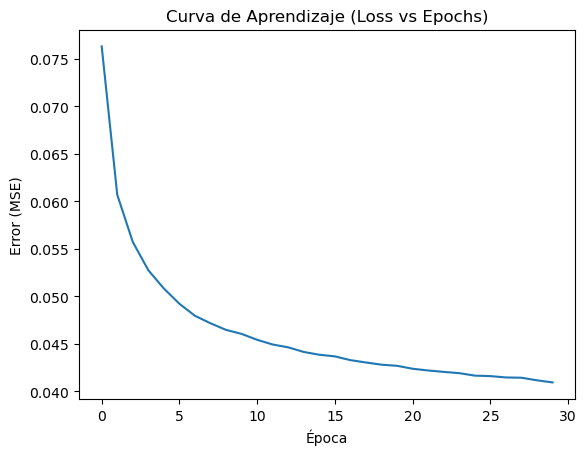

In [43]:
num_epochs = 30 
train_losses = []
print(" Iniciando entrenamiento...")
for epoch in range(num_epochs):
    model.train() 
    running_loss = 0.0
    
    for inputs, targets in train_loader:
        # 1. Resetear gradientes
        optimizer.zero_grad()
        
        # 2. Forward pass (Predecir)
        outputs = model(inputs)
        
        # 3. Calcular error
        loss = criterion(outputs, targets)
        
        # 4. Backward pass (Aprender/Ajustar pesos)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    # Calcular promedio de error en esta época
    epoch_loss = running_loss / len(train_loader)
    train_losses.append(epoch_loss)
    
    if (epoch+1) % 10 == 0:
        print(f"Época [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")
# Graficar la curva de aprendizaje
plt.plot(train_losses)
plt.title('Curva de Aprendizaje (Loss vs Epochs)')
plt.xlabel('Época')
plt.ylabel('Error (MSE)')
plt.show()


Resultados Finales:
R2 Score (Red Neuronal): 0.7539


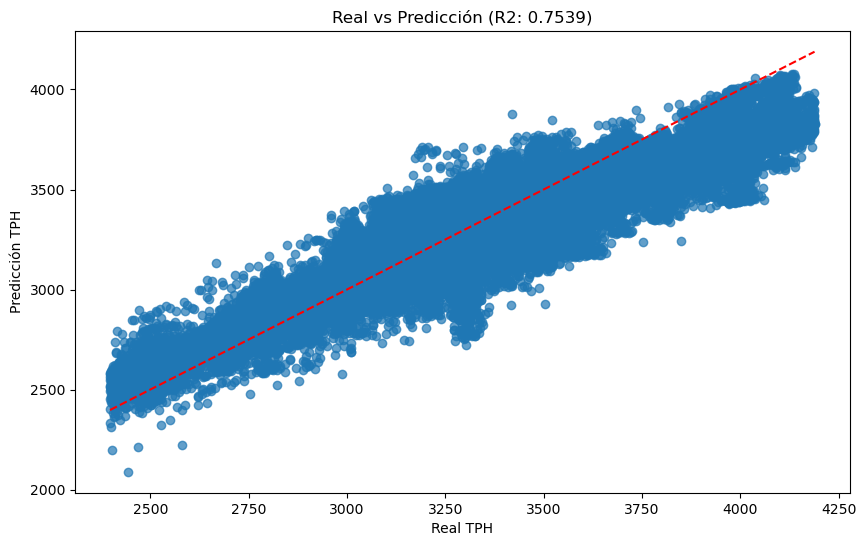

In [44]:
model.eval() 

with torch.no_grad(): 
    # Predecir en datos de test
    y_pred_scaled = model(X_test_tensor)
    
    y_pred_real = scaler_y.inverse_transform(y_pred_scaled.detach().cpu().numpy())
    y_test_real = scaler_y.inverse_transform(y_test_tensor.detach().cpu().numpy())

# Calcular R2 Score
r2 = r2_score(y_test_real, y_pred_real)
print(f"\nResultados Finales:")
print(f"R2 Score (Red Neuronal): {r2:.4f}")

# Comparación visual
plt.figure(figsize=(10,6))
#plt.scatter(y_test_real[:100], y_pred_real[:100], alpha=0.7)
plt.scatter(y_test_real[:], y_pred_real[:], alpha=0.7)
plt.plot([y_test_real.min(), y_test_real.max()], [y_test_real.min(), y_test_real.max()], 'r--')
plt.xlabel('Real TPH')
plt.ylabel('Predicción TPH')
plt.title(f'Real vs Predicción (R2: {r2:.4f})')
plt.show()

 Iniciando Validación Cruzada (TimeSeriesSplit) con 5 particiones...

 Fold 1/5 | Train Size: 80801 | Test Size: 80800
   -> Loss final epoch 30: 0.0229
    R2 Score: 0.8112

 Fold 2/5 | Train Size: 161601 | Test Size: 80800
   -> Loss final epoch 30: 0.0305
    R2 Score: 0.8940

 Fold 3/5 | Train Size: 242401 | Test Size: 80800
   -> Loss final epoch 30: 0.0326
    R2 Score: 0.7426

 Fold 4/5 | Train Size: 323201 | Test Size: 80800
   -> Loss final epoch 30: 0.0415
    R2 Score: 0.8081

 Fold 5/5 | Train Size: 404001 | Test Size: 80800
   -> Loss final epoch 30: 0.0397
    R2 Score: 0.7203

 R2 Promedio Final: 79.52% (+/- 6.09%)


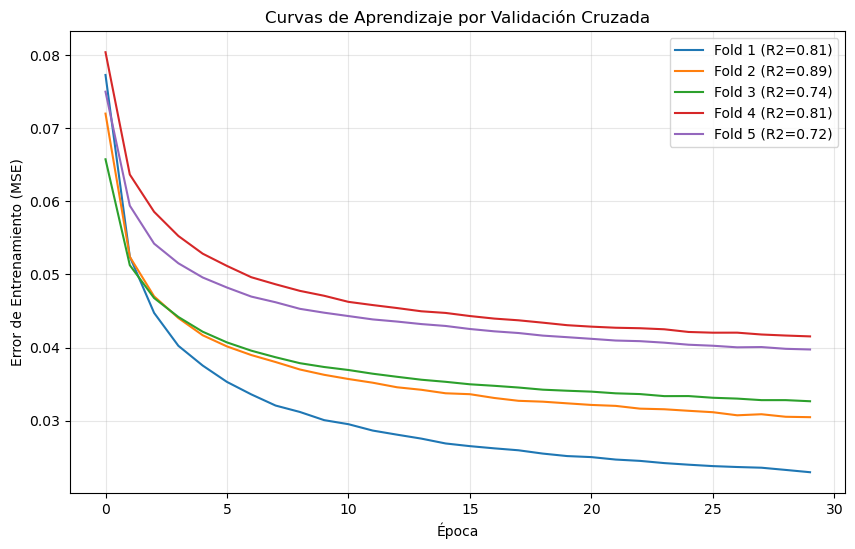

In [46]:

from sklearn.model_selection import TimeSeriesSplit

class SagMillNet(nn.Module):
    def __init__(self, input_size):
        super(SagMillNet, self).__init__()
        # Capa 1: 64 Neuronas + ReLU + Dropout
        self.layer1 = nn.Linear(input_size, 256)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.2) 
        
        # Capa 2: 32 Neuronas
        self.layer2 = nn.Linear(256, 128)
        
        # Salida: 1 Neurona (TPH)
        self.output = nn.Linear(128, 1) 
        
    def forward(self, x):
        x = self.layer1(x)
        x = self.relu(x)
        x = self.dropout(x) # Solo activo durante .train()
        x = self.layer2(x)
        x = self.relu(x)
        x = self.output(x)
        return x

# ==========================================
# 2. PREPARACIÓN DE DATOS BASE
# ==========================================
target_col = 'TPH fresco SAG'
X_raw = df_features.drop(columns=[target_col])
y_raw = df_features[target_col]

# Usamos arrays de Numpy para poder indexar fácilmente
X_np = X_raw.values
y_np = y_raw.values.reshape(-1, 1)

# ==========================================
# 3. BUCLE DE TIME SERIES CROSS-VALIDATION
# ==========================================
n_splits = 5
tscv = TimeSeriesSplit(n_splits=n_splits)

# Configuración de entrenamiento
batch_size = 64
num_epochs = 30 
cv_r2_scores = []      # Para guardar el R2 de cada fold
history_losses = {}    # Para guardar las curvas de aprendizaje

print(f" Iniciando Validación Cruzada (TimeSeriesSplit) con {n_splits} particiones...\n")

for fold, (train_index, test_index) in enumerate(tscv.split(X_np)):
    print(f" Fold {fold+1}/{n_splits} | Train Size: {len(train_index)} | Test Size: {len(test_index)}")

    # --- A. Separar Train/Test para este Fold específico ---
    X_train, X_test = X_np[train_index], X_np[test_index]
    y_train, y_test = y_np[train_index], y_np[test_index]

    # --- B. ESCALADO (StandardScaler) ---
    # ¡CRUCIAL!: Fitear el scaler SOLO con los datos de Train de este fold
    scaler_X = StandardScaler().fit(X_train)
    scaler_y = StandardScaler().fit(y_train)

    X_train_scaled = scaler_X.transform(X_train)
    X_test_scaled  = scaler_X.transform(X_test)
    y_train_scaled = scaler_y.transform(y_train)
    # No transformamos y_test, lo usamos para validar en escala original al final

    # --- C. Tensores y DataLoaders ---
    X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train_scaled, dtype=torch.float32)
    X_test_tensor  = torch.tensor(X_test_scaled, dtype=torch.float32)
    
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    # --- D. INICIALIZAR NUEVO MODELO ---
    # Se crea una instancia nueva cada vez para resetear los pesos
    model = SagMillNet(input_size=X_train.shape[1])
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # --- E. BUCLE DE ENTRENAMIENTO (Training Loop) ---
    fold_losses = []
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        
        for inputs, targets in train_loader:
            optimizer.zero_grad()           # 1. Resetear
            outputs = model(inputs)         # 2. Predecir
            loss = criterion(outputs, targets) # 3. Calcular Error
            loss.backward()                 # 4. Calcular Gradientes
            optimizer.step()                # 5. Actualizar Pesos
            
            running_loss += loss.item()
        
        epoch_loss = running_loss / len(train_loader)
        fold_losses.append(epoch_loss)

    # Guardamos la curva de este fold
    history_losses[fold] = fold_losses
    print(f"   -> Loss final epoch {num_epochs}: {fold_losses[-1]:.4f}")

    # --- F. EVALUACIÓN DEL FOLD ---
    model.eval()
    with torch.no_grad():
        # Predecir en Test
        y_pred_scaled = model(X_test_tensor)
        
        # Des-escalar predicción para comparar peras con peras
        y_pred_real = scaler_y.inverse_transform(y_pred_scaled.detach().numpy())
        
        # Calcular R2
        r2 = r2_score(y_test, y_pred_real) # y_test ya estaba en escala original
        cv_r2_scores.append(r2)
        print(f"    R2 Score: {r2:.4f}\n")

# ==========================================
# 4. RESULTADOS Y VISUALIZACIÓN
# ==========================================
print("="*50)
print(f" R2 Promedio Final: {np.mean(cv_r2_scores):.2%} (+/- {np.std(cv_r2_scores):.2%})")

# Graficar la curva de aprendizaje de todos los folds
plt.figure(figsize=(10, 6))
for fold, losses in history_losses.items():
    plt.plot(losses, label=f'Fold {fold+1} (R2={cv_r2_scores[fold]:.2f})')

plt.title('Curvas de Aprendizaje por Validación Cruzada')
plt.xlabel('Época')
plt.ylabel('Error de Entrenamiento (MSE)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [ ]:
from sklearn.model_selection import KFold  

# ==========================================
# 1. DEFINICIÓN DEL MODELO
# ==========================================
class SagMillNet(nn.Module):
    def __init__(self, input_size):
        super(SagMillNet, self).__init__()
        self.layer1 = nn.Linear(input_size, 256)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.2)
        self.layer2 = nn.Linear(256, 128)
        self.output = nn.Linear(128, 1) 
        
    def forward(self, x):
        x = self.layer1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.layer2(x)
        x = self.relu(x)
        x = self.output(x)
        return x

# ==========================================
# 2. PREPARACIÓN DE DATOS
# ==========================================
target_col = 'TPH fresco SAG'
X_raw = df_features.drop(columns=[target_col])
y_raw = df_features[target_col]

X_np = X_raw.values
y_np = y_raw.values.reshape(-1, 1)

# ==========================================
# 3. BUCLE DE K-FOLD CROSS-VALIDATION
# ==========================================
n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=False, random_state=42)

batch_size = 64
num_epochs = 30 
cv_r2_scores = []      
history_losses = {}    

print(f" Iniciando K-Fold Cross-Validation (K={n_splits})...\n")

for fold, (train_index, test_index) in enumerate(kf.split(X_np)):
    print(f" Fold {fold+1}/{n_splits} | Train Size: {len(train_index)} | Test Size: {len(test_index)}")

    # --- A. Separar Train/Test ---
    X_train, X_test = X_np[train_index], X_np[test_index]
    y_train, y_test = y_np[train_index], y_np[test_index]

    # --- B. ESCALADO ---
    scaler_X = StandardScaler().fit(X_train)
    scaler_y = StandardScaler().fit(y_train)

    X_train_scaled = scaler_X.transform(X_train)
    X_test_scaled  = scaler_X.transform(X_test)
    y_train_scaled = scaler_y.transform(y_train)

    # --- C. Tensores ---
    X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train_scaled, dtype=torch.float32)
    X_test_tensor  = torch.tensor(X_test_scaled, dtype=torch.float32)
    
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    # --- D. INICIALIZAR MODELO ---
    model = SagMillNet(input_size=X_train.shape[1])
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # --- E. ENTRENAMIENTO ---
    fold_losses = []
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        
        epoch_loss = running_loss / len(train_loader)
        fold_losses.append(epoch_loss)

    history_losses[fold] = fold_losses
    print(f"-> Loss Final: {fold_losses[-1]:.4f}")

    # --- F. EVALUACIÓN ---
    model.eval()
    with torch.no_grad():
        y_pred_scaled = model(X_test_tensor)
        y_pred_real = scaler_y.inverse_transform(y_pred_scaled.detach().numpy())
        
        r2 = r2_score(y_test, y_pred_real)
        cv_r2_scores.append(r2)
        print(f"R2 Score: {r2:.4f}\n")

# ==========================================
# 4. RESULTADOS
# ==========================================
print("="*50)
print(f"R2 Promedio (K-Fold): {np.mean(cv_r2_scores):.2%} (+/- {np.std(cv_r2_scores):.2%})")

plt.figure(figsize=(10, 6))
for fold, losses in history_losses.items():
    plt.plot(losses, label=f'Fold {fold+1} (R2={cv_r2_scores[fold]:.2f})')
plt.title('Curvas de Aprendizaje (K-Fold)')
plt.xlabel('Época')
plt.ylabel('MSE Scaled')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

ValueError: Setting a random_state has no effect since shuffle is False. You should leave random_state to its default (None), or set shuffle=True.